# Introduction

In this project, we will delve into the world of unsupervised learning to uncover hidden patterns and structures within a dataset related to racial bias. We will employ two powerful techniques: Latent Dirichlet Allocation (LDA) for topic modeling and K-means clustering for grouping similar documents. Our goal is to explore the dataset without relying on pre-existing labels, providing insights into potential biases and themes.  The dataset we are working with consists of news articles and their associated text. We will preprocess this text data to remove noise and extract meaningful features. This preprocessing is crucial for the success of our unsupervised learning models, as it ensures that the models operate on a clean and relevant set of features.

Our analysis will begin with topic modeling using LDA. This approach will help us to identify the main themes present in the news articles. By examining these themes, we can gain a better understanding of the prevalent narratives and potentially uncover instances of racial bias.

Following topic modeling, we will apply K-means clustering to group the documents based on their content similarity. This clustering will allow us to see how the articles naturally aggregate, which can provide further evidence of bias if certain clusters disproportionately represent specific racial narratives.

Throughout our analysis, we will use various visualization techniques to interpret the results of our models. Visualizations such as word clouds, parallel coordinates plots, and silhouette plots will help us to assess the quality of our topic modeling and clustering, ensuring that our findings are robust and meaningful.  In addition to these analyses, we will perform sensitivity analyses on both the LDA and K-means models. This will involve adjusting key parameters to understand how the models' outputs change with different configurations. By doing so, we can ensure that our conclusions are not sensitive to the particular choices of model parameters.

Our ultimate aim is to contribute to the discourse on racial bias in media by providing data-driven insights. We hope that these insights can be used to foster a more informed and equitable public conversation.

### Import Libraries

First, we need to import all the necessary libraries to handle data manipulation, vectorization, dimensionality reduction, clustering, and visualization....there are alot so strap in.

In [ ]:
import pandas as pd
import numpy as np
import pickle

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import LatentDirichletAllocation     
from sklearn.metrics import davies_bouldin_score, silhouette_score

! pip install gensim
import gensim
from gensim import corpora
from gensim.models import Word2Vec, CoherenceModel               #clustering imports
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models import CoherenceModel

! pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

from sklearn.model_selection import ParameterGrid
from joblib import Parallel, delayed
from sklearn.metrics import make_scorer

!pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

! pip install yellowbrick
! pip install umap-learn
from yellowbrick.text import UMAPVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

import joblib
from pandas.plotting import parallel_coordinates 
from collections import Counter


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 23.3 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 24.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.3/404.3 kB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 48.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 51.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.4
    Not uninstalling numpy at /shared-libs/python3.9/py/lib/python3.9/site-packages, outside environment /root/venv
    Can't uninstall 'numpy'. No files were found to uninstall.

[notice] A new release of pip is available: 23.0.1 -> 24.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
#running slow version of gensim this will update it
# !pip install --upgrade gensim
# !pip install --upgrade pip

### Data Prepocessing

In part one, the newsmediabias-full.csv dataset was processed to filter only on topics pertining to race, drop duplicate rows, and handle missing data.  Additionally contractions were expanded, data lowercased, removal of non-alphabetic characters, tokenization and lemmatization were are applied leaving us with a processed, newsmediabias-clean.csv which is where we will start.

We are going to load the dataset to use for our unsupervised analysis.

In [ ]:
cleaned_data = pd.read_csv('/work/newsmediabias-clean.csv')
cleaned_data['preprocessed_text'].fillna('', inplace=True)
preprocessed_texts = cleaned_data['preprocessed_text']

# Topic Modeling with LDA

Topic modeling is a technique used to identify latent topics within a collection of documents. We will use LDA to discover the main themes in our dataset.  LDA is a generative statistical model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar [2].  In our case, these observations are words in the text, and the unobserved groups are the topics. LDA assumes that each document is a mixutre of a small number of topics and that each word's presence is attributable to one of the document's topics.

The LDA model will be trained on the TF-IDF matrix obtained from our preprocessed text data. We will use the Gensm library's LDA model which is designed to handle large datasets and provides efficient algorithms for topic inference.  To interpret the topics discovered by LDA, we will examine the most probable words associated with each topic.  These word distributions give us insight into the content and focus of each topic. We will also visualize the topics using PyLDAvis, a tool that helps us to interactively explore the topic model.

### TF-IDF Vectorization

We begin by vectorizing our text data using TF-IDF to weigh the importance of words in the documents. This step is crucial for the LDA model to understand the semantic structure of the text. With the data vectorized, we train the LDA model. We will use Gensim for this purpose, as it provides efficient tools for topic modeling.

In [ ]:
#TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(preprocessed_texts)

### LDA using Gensim

Gensim is being used for our topic modeling with LDA because it allows us to efficiently discover the underlying topics in a large text corpus.  The process involves preprocessing the text data, creating a dictionary and corpus, training an LDA model, and evaluating the models performance.  Gensim provides the tools and functionalities needed to accomplish these tasks effectively which is why it was chosen for this project.[5]

In [ ]:
'''
Inputs:
    - preprocessed_texts: A list of preprocessed text data (tokenized and cleaned)
    - num_topics: The desired number of topics for the LDA model
Outputs:
    - lda_model: Trained LDA model representing learned topics
    - coherence_score: Coherence score of the model. Indicates the quality of topics
'''

texts = [word.split() for word in preprocessed_texts]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts] 

#Choo Choo the model
num_topics = 5
lda_model = LdaModel(corpus = corpus,
                    id2word = dictionary,
                    num_topics = num_topics,
                    random_state = 42)

#show topics
for idx, topic in lda_model.print_topics(-1):
    print(f"Topics {idx}: {topic}")
    
#Calculate Coherence score
coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence= 'c_v')
coherence_score = coherence_model.get_coherence()
print(f"Coherence score: {coherence_score}")

Topics 0: 0.025*"race" + 0.015*"racist" + 0.013*"people" + 0.012*"white" + 0.009*"racism" + 0.009*"america" + 0.008*"police" + 0.008*"black" + 0.007*"country" + 0.006*"player"
Topics 1: 0.020*"racist" + 0.019*"n" + 0.018*"trump" + 0.015*"one" + 0.013*"black" + 0.012*"white" + 0.010*"people" + 0.009*"person" + 0.009*"would" + 0.009*"racism"
Topics 2: 0.049*"n" + 0.032*"white" + 0.016*"american" + 0.013*"racial" + 0.011*"comment" + 0.010*"people" + 0.009*"african" + 0.007*"group" + 0.006*"article" + 0.006*"one"
Topics 3: 0.047*"black" + 0.025*"white" + 0.019*"people" + 0.013*"would" + 0.012*"like" + 0.011*"racist" + 0.008*"n" + 0.006*"guy" + 0.006*"fact" + 0.006*"way"
Topics 4: 0.033*"white" + 0.014*"matter" + 0.014*"president" + 0.012*"n" + 0.012*"obama" + 0.012*"trump" + 0.010*"black" + 0.010*"racism" + 0.009*"civil" + 0.009*"racist"
Coherence score: 0.508800587268557


Visualizing Topics with pyLDAvis

To better understand the topics generated by our LDA model, we use pyLDAvis for interactive visualization. This tool allows us to explore the topics, their associated terms, and their relevance to the corpus. An overview and tutorial for LDAvis can be found HERE [1].

In [ ]:
vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)

In [ ]:
#save graph output to save rerunnning time
pyLDAvis.save_html(vis, 'lda_visualization.html')

### Hyperparameter

To find the best LDA model, we will perform hyperarameter tuning.  This involves systematically adjusting the model's parameters and evaluating its performance to find the combination of parameters that yields the best resutls.  

Below we create a extract_topics function that will help prepare the topics in a way the Gensim CoherenceModel can understand.

In [ ]:
def extract_topics(model, feature_names, no_top_words):
    '''
    Inputs:
    - model: a trained LDA model
    - feature_names: A list of words (features)
    - no_top_words: The number of top words to extract per topic
    Outputs:
    - topics: A list of lists; topic and top words
    '''
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topics.append(top_words)
    return topics

no_top_words = 10

Calculate the coherence score for a given LDA model: The below function fits the LDA model to the TF-IDF matrix, extracts the top words for each topic and computes the coherence score using the specificed coherence measure.  A coherence score helps determine if the LDA model has successfully extracted meaningful and interpretable topics from the data. A higher coherence score indicates a better model performance in terms of topic quality and interpretability.

In [ ]:
def calculate_coherence_score(model, tfidf_matrix):
    '''
    Inputs:
    - model: The LDA model to be fitted
    - tfid_matrix: The TF-IDF matrix of the docments
    Outputs:
    - The coherence score of the LDA model
    '''
    lda_model = model.fit(tfidf_matrix)
    topics = extract_topics(lda_model, tfidf_vectorizer.get_feature_names_out(), no_top_words)
    coherence_model = gensim.models.coherencemodel.CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v')
    return coherence_model.get_coherence()

We will define a grid of hyperparameters to explore, including the number of topics, learning decay, and the maximum number of iterations. Using the ParameterGrid from scikit-learn and parallel processing with joblib, we will train multiple LDA models with different combinations of these parameters and select the one with the highest coherence score.  By carefully tuning these hyperparameters, we aim to find an LDA model that captures the underlying topics in our dataset accurately and coherently, providing valuable insights into the themes and potential biases present in the news articles.

In [ ]:
# Hyperparameters to test
param_grid = {
    'n_components': [5, 10, 15, 20],
    'learning_decay': [0.5, 0.7, 0.9],
    'max_iter': [10, 20, 30]
}

def evaluate_lda(params, tfidf_matrix, tfidf_vectorizer, texts, dictionary, no_top_words):
    '''
    Inputs:
    - params: A dictionary of LDA mode parameters
    - tfidf_matrix: the TF-IDF matrix of the documents
    - tfidf_vectorizer: The TF-IDF vectorizer used
    - texts: A list of documents (texts)
    - dictionary: A Gensim dictionary mapping words to IDs
    - no_top_words: The number of top words to extract per topic
    Outputs:
    - lda: The fitted LDA model
    - coherence_score: The coherence score of the LDA model
    '''
    lda = LatentDirichletAllocation(**params, random_state=42).fit(tfidf_matrix)
    topics = extract_topics(lda, tfidf_vectorizer.get_feature_names_out(), no_top_words)
    coherence = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v')
    return lda, coherence.get_coherence()

# get all parameter combos
grid = ParameterGrid(param_grid)

# Run faster young friend
results = Parallel(n_jobs=-1)(delayed(evaluate_lda)(g, tfidf_matrix, tfidf_vectorizer, texts, dictionary, no_top_words) for g in grid)

# Find the best model and parameters
best_lda, best_coherence_score = max(results, key=lambda x: x[1])
best_params = {k: v for k, v in grid[results.index((best_lda, best_coherence_score))].items()}

print('Best Parameters:', best_params)
print('Best Coherence Score:', best_coherence_score)
print(f'Best LDA: {best_lda}')

Best Parameters: {'n_components': 5, 'max_iter': 10, 'learning_decay': 0.5}
Best Coherence Score: 0.4846314044017439
Best LDA: LatentDirichletAllocation(learning_decay=0.5, n_components=5, random_state=42)


Best Parameters: {'n_components': 5, 'max_iter': 10, 'learning_decay': 0.5}
Best Coherence Score: 0.4846314044017439
Best LDA: LatentDirichletAllocation(learning_decay=0.5, n_components=5, random_state=42)

Create Gensim LDA Model

The below code creates a Gensim LDA model using the best parameters found from the sklearn LDA model.  This function initializes the Gensim LDA model with the same parameters as the best sklearn LDA Model.

In [ ]:
'''
Input:
- best_lda: The best sklearn LDA model
Output:
- A Gensim LDA model initialized with the best parameters
'''
# Get the number of topics from the best model
num_topics = best_lda.n_components

# Create a Gensim LDA model with the same parameters as the best sklearn LDA model
gensim_lda = gensim.models.LdaModel(
    corpus=corpus, 
    id2word=dictionary, 
    num_topics=num_topics, 
    alpha=best_lda.get_params()['doc_topic_prior'],
    eta=best_lda.get_params()['topic_word_prior'],
    iterations=best_lda.max_iter
)

### Visalizations

In [ ]:
# Visualize the topics
vis = gensimvis.prepare(gensim_lda, corpus, dictionary)
pyLDAvis.display(vis)

In [ ]:
#save graph output to save rerunnning time
pyLDAvis.save_html(vis, 'lda_best_topics.html')

Visualize Top Words for Each Topic

The below code creates a bar plot for each topic, showing the importance of topic words.

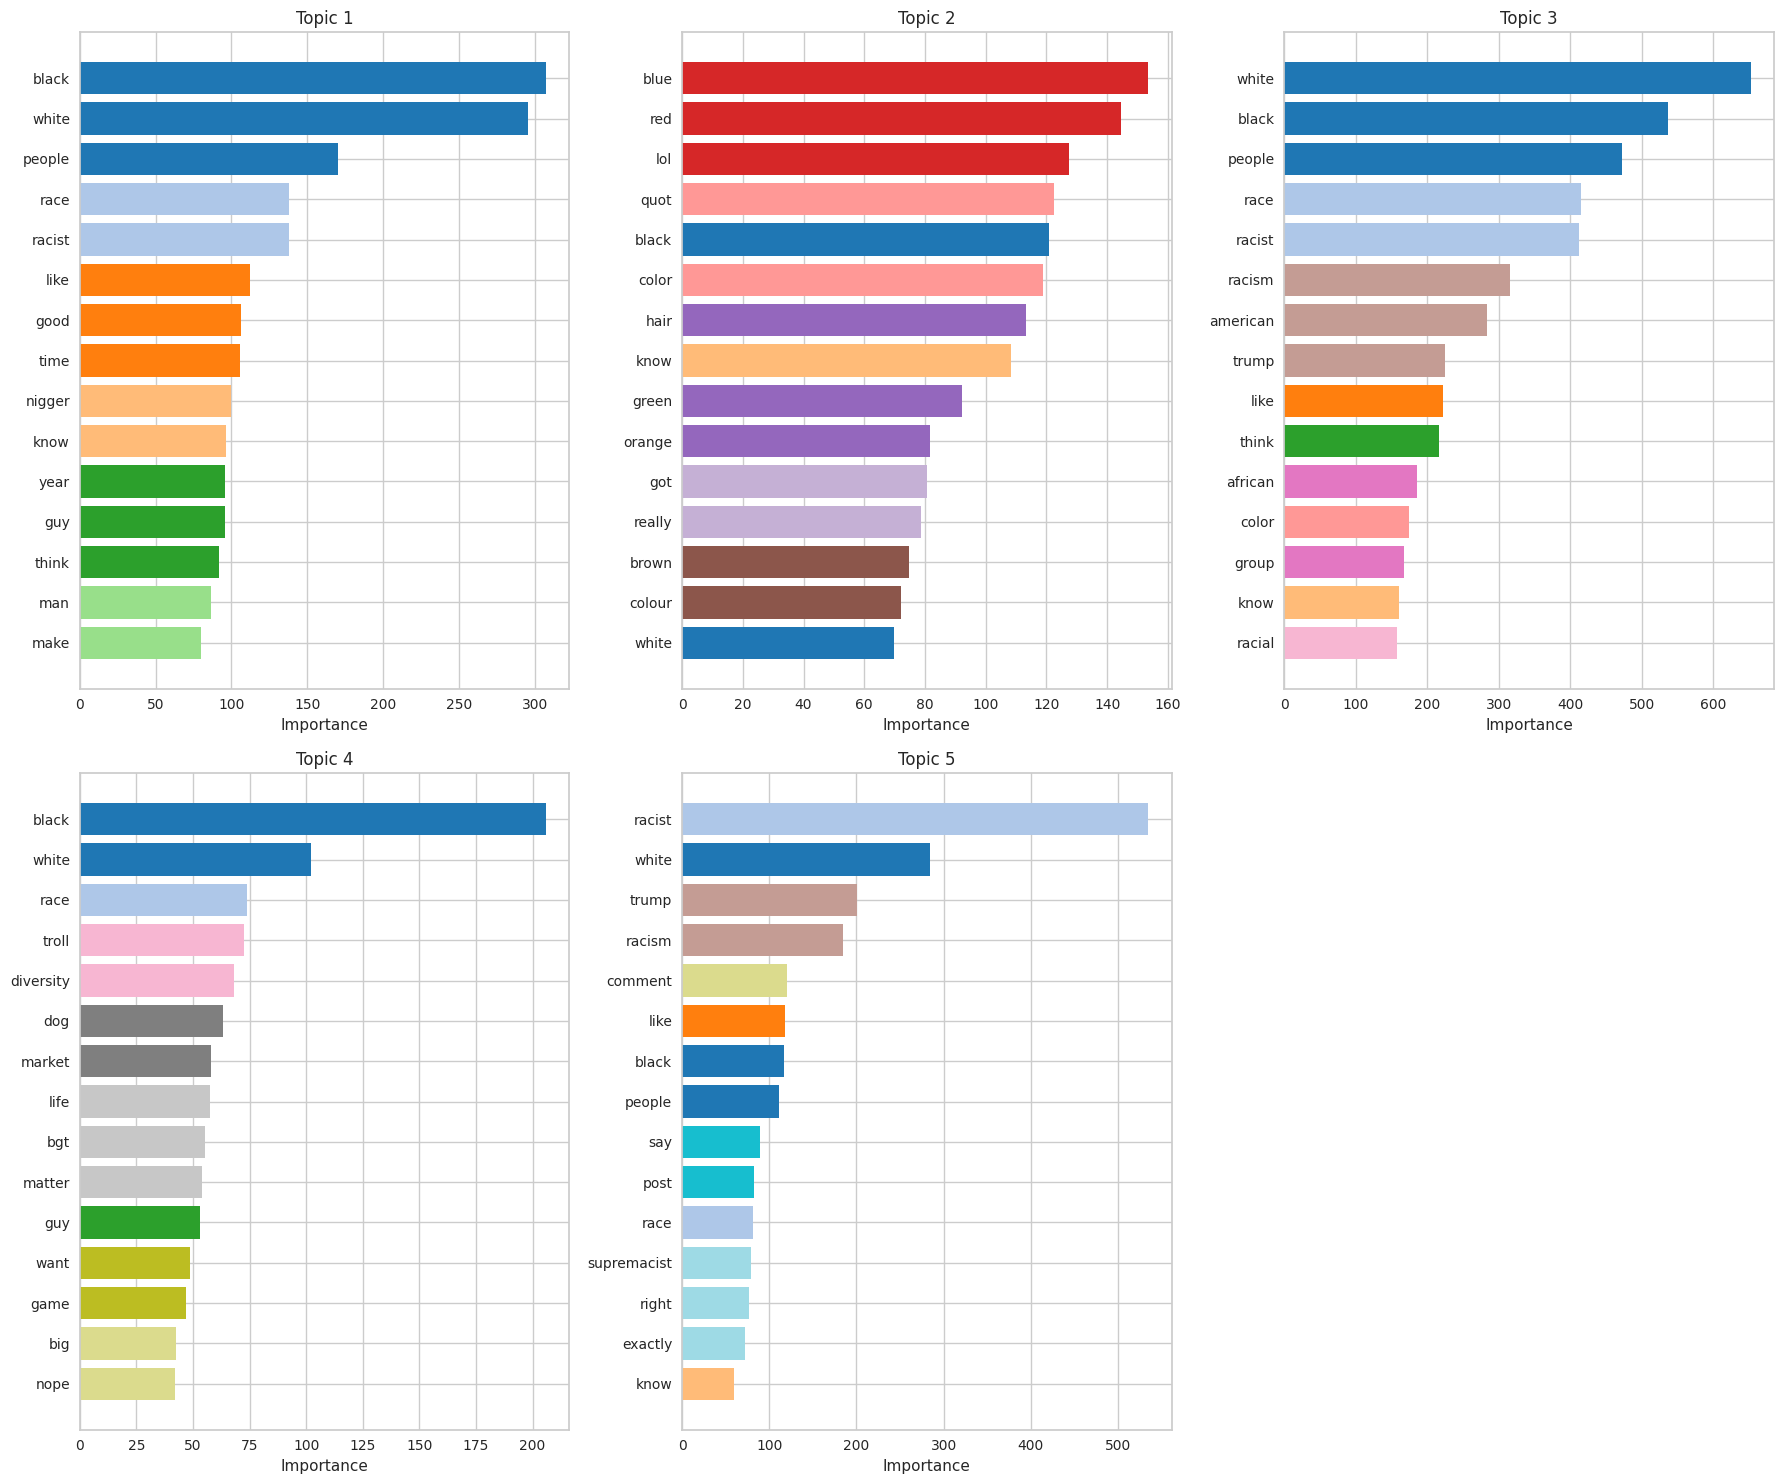

In [ ]:
'''
Input:
- best_lda: The best LDA model.
- tfidf_vectorizer: The TF-IDF vectorizer used to transform the documents.
Output:
- A saved image file containing bar charts
'''

plt.rcParams.update({
    'font.family': 'DejaVu Sans',  # Use a font that is commonly available
    'font.sans-serif': ['DejaVu Sans']
})

# Display top 15 words for each topic
num_topics = len(best_lda.components_)
num_cols = 3
num_rows = (num_topics + num_cols - 1) // num_cols

fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, 15))
axs = axs.flatten()

# Create a color map for words
all_top_words = [tfidf_vectorizer.get_feature_names_out()[idx] for topic in best_lda.components_ for idx in topic.argsort()[:-16:-1]]
word_counts = Counter(all_top_words)
unique_words = list(word_counts.keys())
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_words)))
word_color_map = {word: colors[i] for i, word in enumerate(unique_words)}

for i, topic in enumerate(best_lda.components_):
    top_word_indices = topic.argsort()[:-16:-1]
    words = [tfidf_vectorizer.get_feature_names_out()[idx] for idx in top_word_indices]
    wghts = topic[top_word_indices]
    colors = [word_color_map[word] for word in words]
    axs[i].barh(words, wghts, color=colors)
    axs[i].set_title(f"Topic {i+1}")
    axs[i].invert_yaxis()
    axs[i].set_xlabel("Importance")

for i in range(num_topics, num_rows * num_cols):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.savefig('top_words_vis.png', format='png')

Figure Caption: Top Words in Each Topic - LDA

This figure presents bar charts illustrating the top 10 words for each of the five topics discovered by the Latent Dirichlet Allocation (LDA) model. Each bar chart corresponds to a distinct topic, with the x-axis representing the importance of each word within that topic. The importance is quantified by the word's weight in the LDA model, which reflects how strongly the word is associated with the topic.

Visualize Word Frequency in a Word Cloud: Word clouds are powerful visualization tools used to represent the frequency of words in a text corpus.  They can help with quickly identifying the most prominent terms and themes within a dataset.  Below we will create a series of wordclouds, one for each topic in our LDA model. 

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


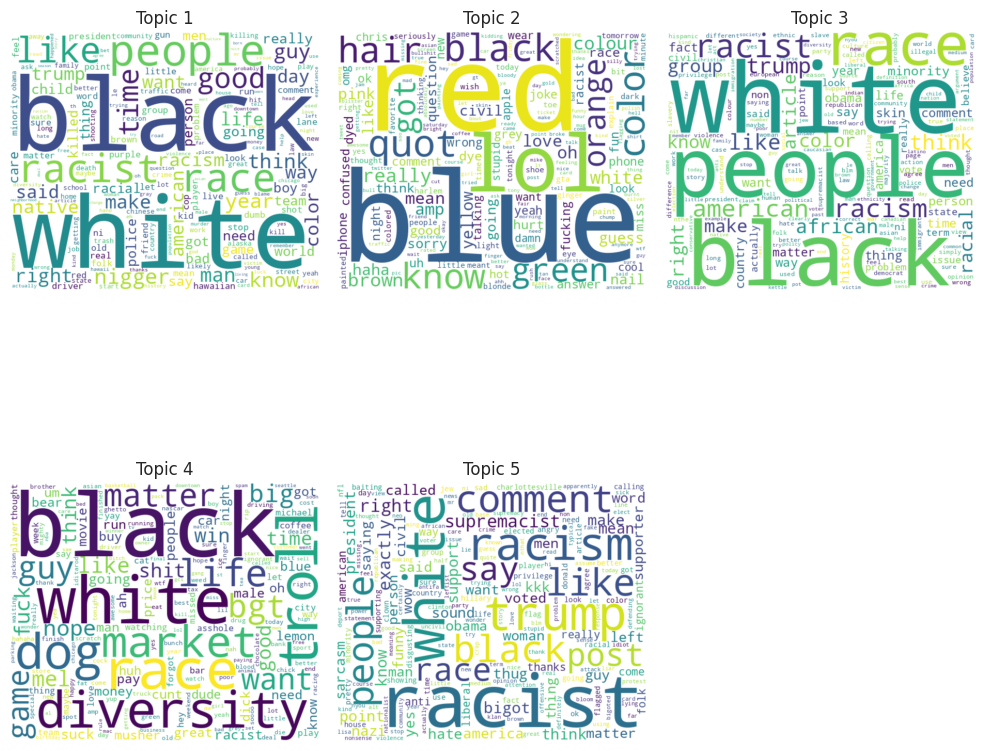

In [ ]:
# Display word cloud for each topic
'''
Inputs:
- best_lda: The best fitted LDA model
- tfidf_vectorizer: The TF-IDf vectorizer used
- num_topics: The number of topics in the LDA model
Outputs:
- A saved image file containing wordclouds
'''
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10))
axs = axs.flatten()

for i, topic in enumerate(best_lda.components_):
    freq = dict(zip(tfidf_vectorizer.get_feature_names(), topic))
    wordcloud = WordCloud(width=600, height=500, background_color='white').generate_from_frequencies(freq)
    axs[i].imshow(wordcloud, interpolation='bilinear')
    axs[i].axis('off')
    axs[i].set_title(f'Topic {i+1}')

for i in range(num_topics, num_rows * num_cols):
    fig.delaxes(axs[i])
    
plt.tight_layout()
plt.savefig('wordcloud_vis.png', format='png')

Figure Caption: Wordcloud- LDA

The wordcloud grphs start to show off the prominent words and themes across the topics. Below is a chart that summarizes the five topics and their associated key words.

| Topic | Description | Key Words |
|---|---|---|
| Topic 1 | Discrimination, inequality, and social justice | black, white, racism, discrimination |
| Topic 2 | Identity and experiences of people of color | culture, history, community, heritage |
| Topic 3 | Impact of racial bias on specific groups | police, crime, poverty, education |
| Topic 4 | Role of media in perpetuating racial bias | news, media, coverage, reporting |
| Topic 5 | Importance of diversity and inclusion | diversity, inclusion, representation, equality |

# K-Means Clustering

K-means clustering is an unsupervised learning algorithm that partitions a set of observations into k clusters based on the nearest mean. In our case, we will use k-means to group the documents into clusters where each document belongs to the cluster with the nearest mean, serving as a prototype of the cluster.

We start by training a Word2Vec model to generate word embeddings. These embeddings capture the semantic relationships between words and will serve as features for clustering.

To find the optimal number of clusters, we will use the Davies-Bouldin index, which is an internal evaluation method to evaluate the clustering algorithm's performance. It is defined as the average similarity between each cluster and its most similar one, where similarity is a measure that compares the intra-cluster similarity with the inter-cluster similarity.  

In [ ]:
'''
Inputs:
- preprocessed_texts: A list of preprocessed text documents
Outputs:
- model: A trained Word2Vec model
'''

tokenized_texts = [text.lower().split() for text in preprocessed_texts]

# Train Word2Vec model
size = 100  
min_count = 5  
workers = 4  
window = 5  
model = Word2Vec(tokenized_texts, vector_size=size, min_count=min_count, workers=workers, window=window)

In [ ]:
# Create document vectors by averaging the word vectors
# Needed to perform tasks that require a numberical representation of the documents
doc_vectors = []
for text in tokenized_texts:
    vector = np.zeros(size)
    count = 0
    for word in text:
        if word in model.wv:
            vector += model.wv[word]
            count += 1
    if count > 0:
        vector /= count
    doc_vectors.append(vector)

### Hyperparameter Tuning

We will perform hyperparameter tuning by varying the number of clusters and selecting the one that minimizes the Davies-Bouldin index, indicating better clustering performance.

In [ ]:
# Hyperparameter tuning using Davies-Bouldin score
'''
Inputs:
- doc_vectors: A list of document vectors 
- max_cluster: The maximum number of clusters to test
Outputs:
- db_scores: A list of Davies-Bouldin scores, one for each number of clusters tested.
- num_cluster: A list of the number of clusters tested
'''
db_scores = []
num_clusters = []
max_clusters = 20  

for k in range(2, max_clusters+1):
    kmeans_model = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=10, random_state=42)
    kmeans_model.fit(doc_vectors)
    clusters = kmeans_model.labels_
    db_score = davies_bouldin_score(doc_vectors, clusters)
    db_scores.append(db_score)
    num_clusters.append(k)
    print(f'Number of clusters: {k}, Davies-Bouldin score: {db_score}')

Number of clusters: 2, Davies-Bouldin score: 2.627767273144255
Number of clusters: 3, Davies-Bouldin score: 2.349731113263465
Number of clusters: 4, Davies-Bouldin score: 2.2779700151869573
Number of clusters: 5, Davies-Bouldin score: 2.119798636151003
Number of clusters: 6, Davies-Bouldin score: 2.1349144517204564
Number of clusters: 7, Davies-Bouldin score: 2.0482751587909984
Number of clusters: 8, Davies-Bouldin score: 1.9611125128537403
Number of clusters: 9, Davies-Bouldin score: 1.9889220936473204
Number of clusters: 10, Davies-Bouldin score: 1.9838287327377278
Number of clusters: 11, Davies-Bouldin score: 1.9380466131652931
Number of clusters: 12, Davies-Bouldin score: 1.9132915755253481
Number of clusters: 13, Davies-Bouldin score: 1.8466721960268013
Number of clusters: 14, Davies-Bouldin score: 1.8349612789155223
Number of clusters: 15, Davies-Bouldin score: 1.7871746166540161
Number of clusters: 16, Davies-Bouldin score: 1.7846679694492564
Number of clusters: 17, Davies-Bould

In [ ]:
#save db_scores as datframe
db_results = pd.DataFrame({'Number of Clusters': num_clusters, 'Davies-Bouldin Score': db_scores})

# Save the DataFrame to a CSV file
db_results.to_csv('db_hyperparameter_tuning_results.csv', index=False)

In [ ]:
db_results

,Number of Clusters,Davies-Bouldin Score
0,2,2.627767
1,3,2.349731
2,4,2.277970
3,5,2.119799
4,6,2.134914
5,7,2.048275
6,8,1.961113
7,9,1.988922
8,10,1.983829
9,11,1.938047


Now that our hyperprameter tuning is complete, we will save the cluster size with the lowest Davies-Bouldin score for use in our model training and visualizations.

In [ ]:
# Find the optimal number of clusters
optimal_k = db_scores.index(min(db_scores)) + 2  #need to adjust for index variance -_-
print(f'Optimal number of clusters: {optimal_k}')


Optimal number of clusters: 17


### Final K-means Training

Now that we have identified the optimal number of clusters using the Davies-Bouldin index, we will train the final k-means model with the best hyperparameters.  This model will be used to assign each document to one of the k cluters based on the similarity of their Word2Vec document vectors.

In [ ]:
# Train the final model with the optimal number of clusters
final_kmeans_model = KMeans(n_clusters=optimal_k, init='k-means++', max_iter=100, n_init=1, random_state=42)
final_kmeans_model.fit(doc_vectors)
final_clusters = final_kmeans_model.labels_

### Visualizations

To visualize the clusters and interpret the results of the K-means clustering, we will prepare the data for plotting. We will create a new DataFrame that includes the cluster labels assigned by the K-means model and the document vectors.

In [ ]:
# Create a new dataframe with the cluster labels
clustered_data = cleaned_data[['preprocessed_text']].copy()
clustered_data['cluster'] = final_clusters
clustered_data['doc_vectors'] = doc_vectors

# Save the new dataframe with cluster labels
clustered_data.to_csv('/work/newsmediabias-clustered.csv', index=False)

## Visualizing Clusters with PCA and t-SNE 

Principal Component Analysis (PCA) and t-Distributed Stochastic Neighbor Embedding (t-SNE) are dimensionality reduction techniques that we will use to visualize the high-dimensional document vectors in a 2D space. PCA seeks to find the orthogonal projection of the data onto a lower-dimensional space that maximizes the variance, while t-SNE is particularly well-suited for the visualization of high-dimensional datasets, as it preserves the local structure of the data. We will compare the two tecniques using the optimal cluster size as determined by the Davies-Bouldin score.

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

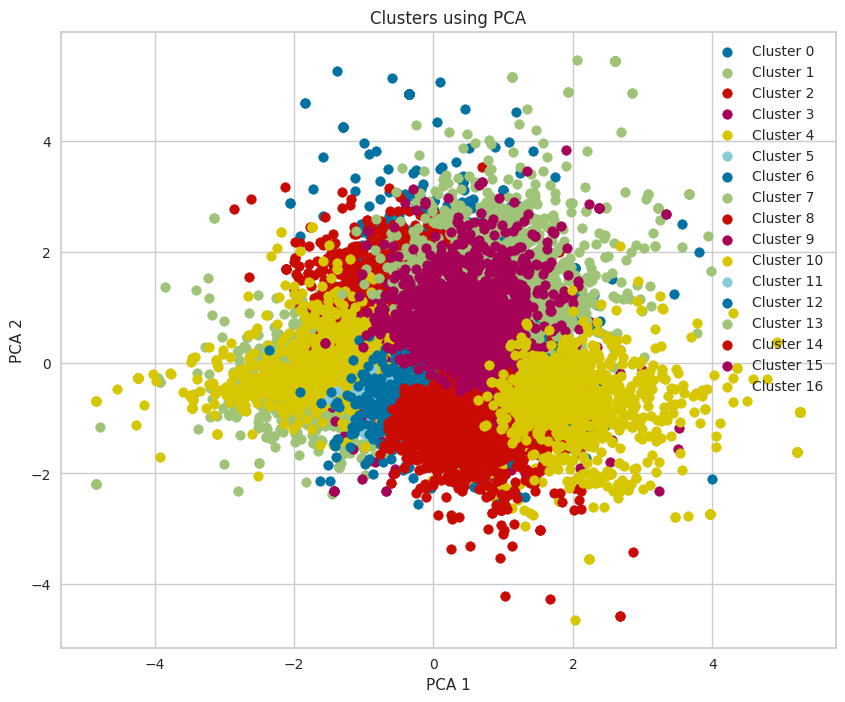

In [ ]:
# Reduce the dimensionality of the document vectors to 2D using PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(doc_vectors)

plt.rcParams['font.sans-serif'] = ['Arial'] 
# Plot the PCA results
plt.figure(figsize=(10, 8))
for i in range(optimal_k):
    plt.scatter(pca_result[final_clusters == i, 0], pca_result[final_clusters == i, 1], label=f'Cluster {i}')
plt.title('Clusters using PCA')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.savefig('PCA_plot.png', format='png')

Figure Caption: Clusters using PCA

This scatter plot visualizes the document clusters identified through KMeans clustering, reduced to two dimensions using Principal Component Analysis (PCA). Each colored point represents a document, and different colors correspond to different clusters. The optimal number of clusters (k=17) was determined using Davies-Bouldin score optimization. This visualization helps to observe the distribution and separation of clusters, highlighting the distinct groupings of documents based on their textual content.

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families

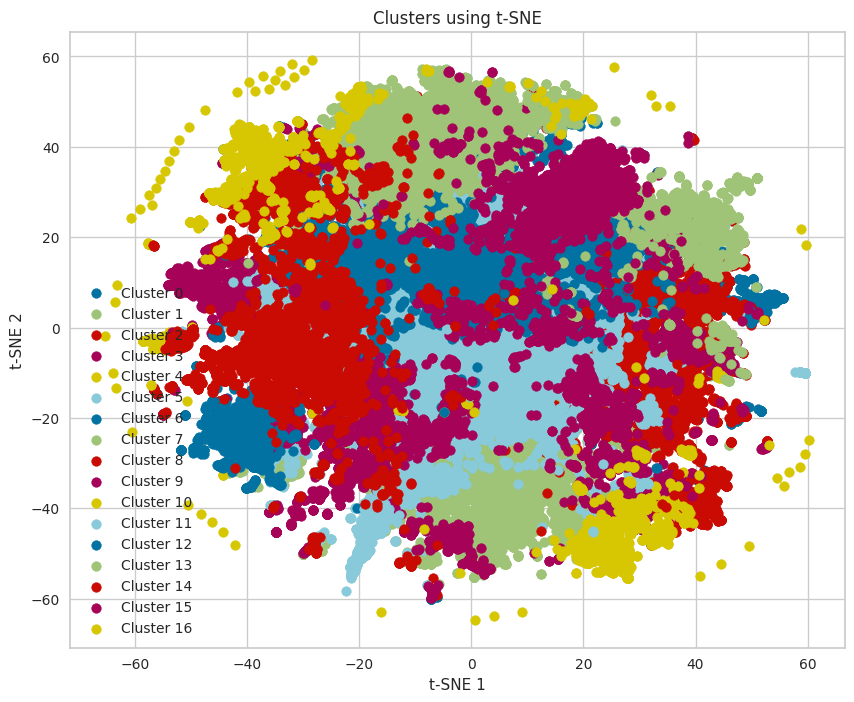

In [ ]:
# Reduce the dimensionality of the document vectors to 2D using t-SNE

doc_vectors = np.array(doc_vectors)
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(doc_vectors)

plt.rcParams['font.sans-serif'] = ['Arial'] 

# Plot the t-SNE results
plt.figure(figsize=(10, 8))
for i in range(optimal_k):
    plt.scatter(tsne_result[final_clusters == i, 0], tsne_result[final_clusters == i, 1], label=f'Cluster {i}')
plt.title('Clusters using t-SNE')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()

plt.savefig('tSNE_plot.png', format='png')
#plt.show()

Figure Caption: Clusters using t-SNE

This scatter plot visualizes the document clusters identified through t-SNE, which reduces the dimensionality of document vectors from 100 dimensions (as generated by Word2Vec embeddings) down to two dimensions. Each colored point represents a document, and different colors correspond to different clusters. The optimal number of clusters (k=17) was determined using Davies-Bouldin score optimization. This visualization helps to observe the distribution and separation of clusters, highlighting the distinct groupings of documents based on their textual content.

Dimensionality Reduction Discussion

Although both PCA and t-SNE are dimensionality reduction techniques, as we can see from the results they have different strengths and weaknesses.  PCA preserves global data structure by capturing maximum variance in linear combinations of features, but it often results in overlapping clusters due to its linear nature.  In contrast, t-SNE excels at revealing distinct clusters by maintaining local data structure, making it effective for visualizing non-linear relationships [4].  However, t-SNE is computationally intensive and sensitive to parameter settings.  While PCA is faster and simpler, t-SNE provides clearer cluster visualizations and is the better dimensionality reduction technique for our project.

Cluster Size Bar Chart

To understand the distribution of documents across the clusters, we will create a bar plot that shows the size of each cluster. This visualization will help us to assess the balance of the clustering and identify any clusters that are significantly larger or smaller than the others, which might indicate different patterns in the data.

/tmp/ipykernel_41/260406140.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.arange(len(clusters)), y=clusters, palette='viridis')
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following fa

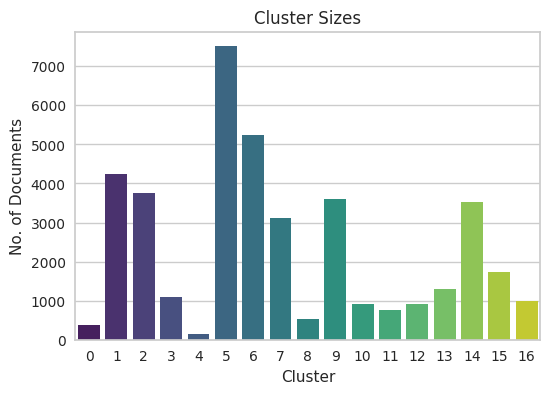

In [ ]:
# Count documents in clusters
clusters = np.bincount(final_clusters)

# The plot thickens
plt.figure(figsize=(6,4))
sns.barplot(x=np.arange(len(clusters)), y=clusters, palette='viridis')
plt.xlabel('Cluster')
plt.ylabel('No. of Documents')
plt.title('Cluster Sizes')

plt.savefig('cluster_bar_plot.png', format='png')
#plt.show()

Figure Caption: Visualizing Cluster Sizes

This bar plot illustrates the distribution of document counts across 17 distinct clusters. Each bar corresponds to one of the clusters, labeled from 0 to 16. The height of each bar represents the number of documents within that cluster. Notably, Cluster 5 stands out with a significantly larger document count compared to other clusters.

Parallel Coordinates Plot

A parallel coordinates plot is a common way of visualizing high-dimensional datasets. It allows us to see the relationships between different dimensions and how they relate to the cluster assignments. Each document is represented as a line, and each dimension (in our case, the components of the document vectors) is represented as a parallel axis. The plot will help us to visualize the separation of clusters in the multi-dimensional space.

/tmp/ipykernel_41/3805850049.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['cluster'] = df['cluster']
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont

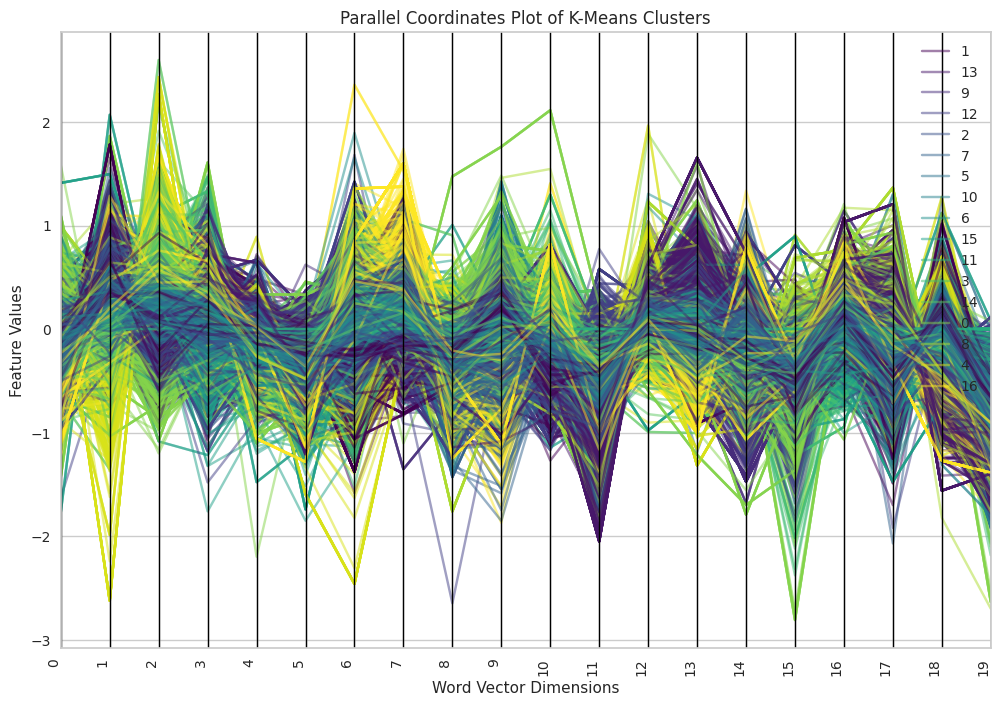

In [ ]:
#Parallel Coordinates Plot
from pandas.plotting import parallel_coordinates 
df = pd.DataFrame(doc_vectors)
df['cluster'] = final_kmeans_model.labels_

# Reduce the number of dimensions
subset_of_columns = df.columns[:20] 
df_subset = df[subset_of_columns]
df_subset['cluster'] = df['cluster']

# Plot the parallel coordinates
plt.figure(figsize=(12, 8))
parallel_coordinates(df_subset, 'cluster', colormap='viridis', alpha=0.5)

plt.grid(True)
plt.xticks(rotation=90, ha='right')

plt.title('Parallel Coordinates Plot of K-Means Clusters')
plt.xlabel('Word Vector Dimensions')
plt.ylabel('Feature Values')

plt.savefig('parallel_coord_plot.png', format='png')

Figure Caption: Parallel Coordinate Plot

This Parallel Coordinate Plot represents mult-dimensional data using parallel axes, where each line corresponds to an observation (data point). The vertical axes represent different features derived from word vectors. These word vectors capture semantic meaning, context, or similarity. The colored lines intersect these axes, indicating the values of each feature for a given observation.  The distinct colors represent clusters identified by the K-means algoritm. For instance, Cluster 5 exhibits similar paths across teh axes, suggesting similarity within that group.  In contrast, other clusters show more variation, indicating a wider range of characteristics. 

Silhouette Plot

Silhouette Plots visually assesses the quality of clusters by showing how well-separated individual clusters are within a dataset. Positve silhouette coefficients indicate that data points within a cluster are more similar to each other than to points in other clusters, while negative coefficients suggest potential overlap or misclassifications[3].  Silhouette plots can help determine the optimal number of clusters, identify poorly matched data points, and guide decsions on refining cluster assignments.

We will use the silhouette plot to evaluate the quality of our K-means clustering. A good clustering result will have a silhouette plot where most points have a high silhouette coefficient, indicating that the clusters are well-separated and the data points are appropriately assigned.

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

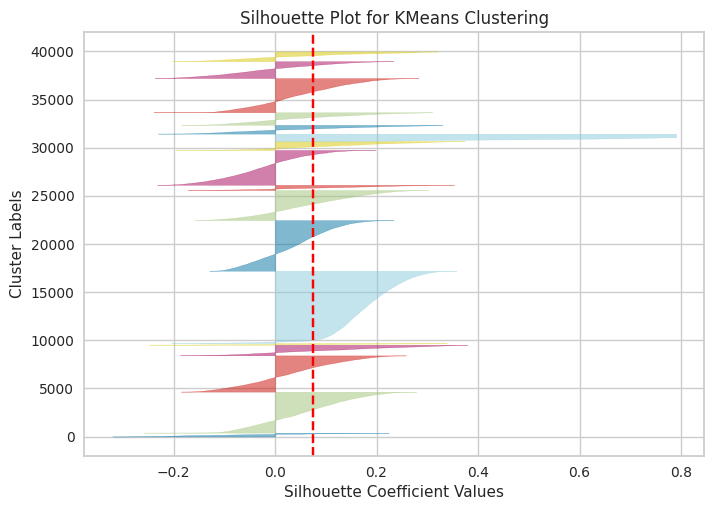

In [ ]:
# Silhouette plot for K-means
silhouette_visualizer = SilhouetteVisualizer(final_kmeans_model, colors='yellowbrick')
silhouette_visualizer.fit(doc_vectors)

plt.title('Silhouette Plot for KMeans Clustering')
plt.xlabel('Silhouette Coefficient Values')
plt.ylabel('Cluster Labels')

plt.savefig('silhouette_plot.png', format='png')

Figure Caption: Silhouette Plot for K-Means Clustering

This Silhouette Plot is illustrating the distribution of silhouette coefficient values across different clusters obtained from KMeans clustering, highlighting potential strengths and weaknesses in cluster formation. Most of the data falls within the range of approximately 0.2 to just above 0.6 on the Silhouette Coefficent Values axis.  This indicates that many data points are well matched to their own clusters and have positive silhouette coefficients.  The thickness of silhouette plots provides insights into separation.  Most clusters so good separation, as their silhouette plots do nto cross significantly into negatve values.  However, some clusters have portions that dip below zero, suggesting potential overlap or misassignment.  Overall, clusters exhibit moderate separation indicating the majority of the data points are well-assigned althought there are areas for improvement.  Addressing some of the overlapping regions by checking for outliers or more indepth Hyperparameter tuning could enhance the cluster quality.

# Sensitivity Analysis

Before we delve into the sensitivity analysis, let's understand why it's important. Sensitivity analysis helps us determine how robust our model is to changes in its hyperparameters. By analyzing the coherence scores for LDA and Davies-Bouldin scores for K-means across a range of values around the optimal parameters, we can gain insights into the stability of our models and the confidence we can have in our results.

### Sensitivity Analysis for LDA

Sensitivity analysis for LDA involves checking how sensitive the model is to changes in the number of topics. We will vary the number of topics around the optimal value found during hyperparameter tuning and evaluate the coherence score for each model.

In [ ]:
# Sensitivity analysis for LDA
n_components_range = range(best_params['n_components']-1, best_params['n_components']+4)
lda_coherence_scores = []

for n_component in n_components_range:
    lda = LatentDirichletAllocation(n_components=n_component, 
                                    learning_decay=best_params['learning_decay'],  
                                    max_iter=best_params['max_iter'],
                                    random_state=42)
    lda.fit(tfidf_matrix)
    coherence_score = calculate_coherence_score(lda, tfidf_matrix)  
    lda_coherence_scores.append(coherence_score)

for i, score in enumerate(lda_coherence_scores):
    print(f"n_components: {n_components_range[i]}, Coherence Score: {score}")

n_components: 4, Coherence Score: 0.4657396133780833
n_components: 5, Coherence Score: 0.4846314044017439
n_components: 6, Coherence Score: 0.48332965648539555
n_components: 7, Coherence Score: 0.4736278690775037
n_components: 8, Coherence Score: 0.42617532990106155


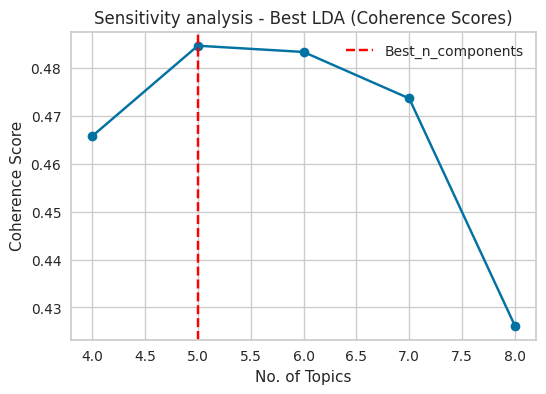

In [ ]:
# Plot LDA sensitivity analysis
plt.figure(figsize=(6,4))
plt.plot(n_components_range, lda_coherence_scores, marker='o')
plt.xlabel('No. of Topics')
plt.ylabel('Coherence Score')
plt.title('Sensitivity analysis - Best LDA (Coherence Scores)')
plt.axvline(x=best_params['n_components'], color='red', linestyle='--', label='Best_n_components')
plt.legend()
plt.savefig('LDA_Sensitivity_plot.png', format='png')
#plt.show()

Figure Caption: Sensitivity Analysis - LDA

The sensitivity analysis plot depicts coherence scores for different numbers of topics (components) in an LDA (Latent Dirichlet Allocation) model. The red dashed line indicates the optimal number of topics (Best_n_components = 5), which maximizes coherence. Coherence scores help evaluate the quality of topic modeling.  The x-axis represents the number of topic count (ranging from 4.0 to 8.0), evaluating variance from the optimal 5 topics. The y-axis shows coherence scores (0.42 to 0.49).  The graph line starts near 0.465, reaches its peak at ~0.489, and gradually  declines 0.424 as the number of topics increase.

### Sensitivity Analysis for K-means

Similarly, we will perform a sensitivity analysis for K-means by varying the number of clusters around the optimal value and calculating the Davies-Bouldin index for each model. This will ensure that our choice of the number of clusters is robust and that the clustering performance does not deteriorate with minor changes in this parameter.

In [ ]:
# Sensitivity analysis for K-means
num_clusters_range = range(optimal_k-2, optimal_k+3)
kmeans_db_scores = []

for num_cluster in num_clusters_range:
    if num_cluster > 0:  # Ensure the number of clusters is at least 1
        kmeans = KMeans(n_clusters=num_cluster, init='k-means++', max_iter=100, n_init=1, random_state=42)
        kmeans.fit(doc_vectors)
        db_score = davies_bouldin_score(doc_vectors, kmeans.labels_)
        kmeans_db_scores.append(db_score)
        print(f'Number of clusters: {num_cluster}, Davies-Bouldin score: {db_score}')

Number of clusters: 15, Davies-Bouldin score: 1.8743881526958974
Number of clusters: 16, Davies-Bouldin score: 1.818525801361869
Number of clusters: 17, Davies-Bouldin score: 1.7539725871536471
Number of clusters: 18, Davies-Bouldin score: 1.8311737543185873
Number of clusters: 19, Davies-Bouldin score: 1.864315154971865


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not fou

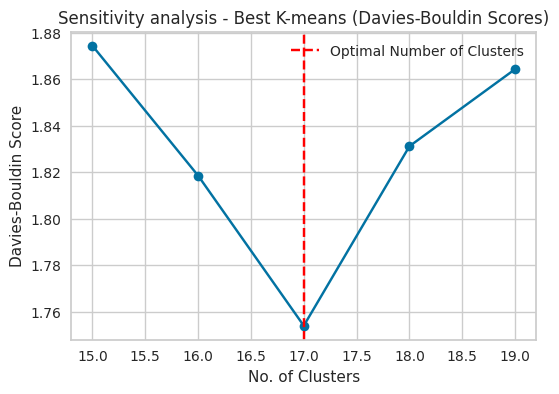

In [ ]:
#Plot k-means sensitivity
plt.figure(figsize=(6, 4))
plt.plot(num_clusters_range, kmeans_db_scores, marker='o')
plt.xlabel('No. of Clusters', fontfamily='Arial')  # Use Times New Roman
plt.ylabel('Davies-Bouldin Score', fontfamily='Arial')
plt.title('Sensitivity analysis - Best K-means (Davies-Bouldin Scores)', fontfamily='Arial')
plt.axvline(x=optimal_k, color='red', linestyle='--', label='Optimal Number of Clusters')
plt.legend()

plt.savefig('K-means_sensitivity_plot.png', format='png')

Figure Caption: Sensitivity Analysis - Best K-means

The Sensitivity Analysis plot depicts the Davies-Bouldin Scores agianst different numbers of clusters used in a K-means clustering model.  The x-axis represents the number of clusters (ranging from 15 to 19), while the y-axis represents the Davies-Bouldin Score (ranging from 1.75 to 1.88).  The graph forms a 'V' shape, with the lowest score occuring at the optimal k = 17, indicating better separation between clusters. As the number of clusters increases beyond this point, the score gradually rises.

# Conclusion

In this project, we have successfully applied unsupervised learning techniques to explore the racial bias dataset. Through the use of LDA and K-means clustering, we have identified underlying topics and grouped similar documents together. The sensitivity analyses for both models have provided us with additional confidence in the stability of our findings.

Our results suggest that there are distinct patterns and clusters within the dataset that can inform further research into racial bias. The interactive visualizations and detailed plots have allowed us to gain a deeper understanding of the model outputs and the structure of the dataset.

# References

[1] ASA Statistical Computing & Graphics Sections. (2014, September). LDAvis: A method for visualizing and interpreting topic models [Video file]. YouTube. https://www.youtube.com/watch?v=IksL96ls4o0 

[2] Awan-Ur-Rahman. (2020, April 12). Latent Dirichlet Allocation (LDA): A Guide to Probabilistic Modeling Approach for Topic Discovery. Towards Data Science. https://towardsdatascience.com/latent-dirichlet-allocation-lda-a-guide-to-probabilistic-modeling-approach-for-topic-discovery-8cb97c08da3c 

[3] Benjamin, B., & Ziegler, M. (n.d.). Silhouette Visualizer. In Scikit-Yellowbrick Documentation. Retrieved [June 1, 2024], from https://www.scikit-yb.org/en/develop/api/cluster/silhouette.html 

[4] Babu, R. (2020, March 17). Understanding PCA and T-SNE intuitively. Analytics Vidhya (Medium). https://towardsdatascience.com/understanding-pca-and-t-sne-intuitively-126000205e7 

[5] Machine Learning Plus. (n.d.). Gensim Overview. Machine Learning Plus. Retrieved [June 4, 2024], from https://www.machinelearningplus.com/nlp/gensim-tutorial/ 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b1c72295-175f-4acc-b145-1e90e876d4e6' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>